# Transit_classification 
## Ensemble algorithms - part I

In the past month, we experimented classification on various datasets:

- white noise only; 
- white noise + red noise;
- planets with various size and size distributions;
- planets with various periods.

For each datasets, we also explored two type of features: 

- features from light curves. 
- features from frequency spectra of light curves. 

We also applied various algorithms for the classifications, including: 

- SVC
- Random Forest Classifer
- Gradient Boosting Classifer 

Today, we want to **combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator**.

We start with introducing the performance of each individual algorithms for the data set that's closest to real data. We will use the simulated data with both white and red noise, three type of planet with realistic planet ratios, and allow the planets to have various periods.  

To speed up the process, we performed the **data manipulation** and **feature selection** ahead and saved the opitimzied feature into individual file for different algorithms. 
For details, go through all the other note books in the git repository. 

In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/chelsea/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is

Let's introduce the diagnostics we use for each algorithms:

   - confusion matrix
   - f1 score 
   - ROC curve
   - FP/FN histogram 

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['false positives', 'transits'], rotation=45)
    plt.yticks(tick_marks, ['false positives', 'transits'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def fit(model,name,data):
    trainX,trainY,testX,testY,X,Y=data
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    score = metrics.f1_score(predY, testY)
    cvscore= cross_val_score(model, X, Y, cv = 5, scoring = 'f1')
    print "#####################################"
    print "Result using",model
    print "f1 score from train test split %f" % score
    print "f1 score from CV5 %f" % np.mean(cvscore)
    cm = metrics.confusion_matrix(testY, predY)
    plot_confusion_matrix(cm)
    
    print cm
    make_ROC_curve(testY,predY,name)
    return

In [4]:
def check_FPs(model,testX,testY,testIDs):
    predY = model.predict(testX)
    index=predY==testY
    bins=np.linspace(1000,7000,13)
    print bins
    plt.hist(testIDs[index],bins=bins)
    plt.hist(testIDs[~index],bins=bins)
    return

In [5]:
def make_ROC_curve(testY, predY, name):
    fig2 = plt.figure()
    ax= fig2.add_subplot(1,1,1)
    fpr, tpr, _ = roc_curve(testY, predY)
    ax.plot(fpr, tpr, label = name)
    ax.set_title(('ROC Curve for %s') % name)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

## Light Curve Features

In [6]:
lc_data=pd.read_csv("data/BL_CR_ALL_features.csv",index_col=0)
lc_data.head()

,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,...,P2,P20,P3,P4,P5,P6,P7,P8,P9,Y
0,0.540434,0.037771,0.172683,0.097716,-0.018738,-0.083855,-0.015305,-0.024479,0.072492,-0.020243,...,0.074023,0.012748,0.000131,0.124444,0.065360,-0.160775,-0.013139,0.036453,0.245333,1
1,-2.532882,-0.789132,-2.246332,3.378265,0.235956,1.479276,1.040072,6.274015,-1.205878,3.184005,...,-0.831484,1.836102,1.826742,-1.016748,3.884804,-1.050683,1.477184,-0.394765,-0.925600,0
2,0.361666,-0.019825,-0.033318,0.230521,0.107373,0.074019,-0.091474,-0.176952,0.110016,-0.159433,...,0.108182,-0.188699,-0.095562,-0.009367,0.486376,0.030885,-0.054621,-0.174604,0.060807,0
3,0.380572,0.206872,0.113220,0.255521,0.045251,0.123499,-0.005128,0.010042,-0.199220,0.023942,...,-0.004947,-0.090793,0.249673,0.129414,-0.117161,0.084759,0.178725,-0.184050,-0.199539,0
4,0.525997,-0.017016,-0.022579,0.005492,0.037668,-0.012379,0.006706,0.000026,0.011609,0.005270,...,-0.040689,0.004691,0.033036,0.053111,0.014616,-0.021634,-0.014654,-0.024405,0.006357,0


### SVM

In [7]:
X=lc_data.drop('Y',axis=1)
Y=lc_data['Y']
#IDs=lc_darta['ID']
X=StandardScaler().fit_transform(X)
trainX, testX, trainY, testY= train_test_split(X, Y,test_size = 0.2)

#####################################
Result using SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
f1 score from train test split 0.921450
f1 score from CV5 0.909038
[[253  36]
 [ 16 305]]


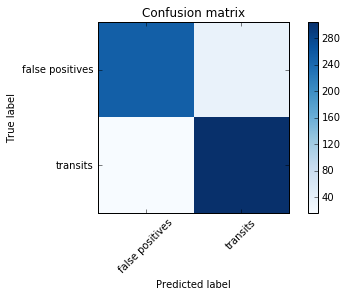

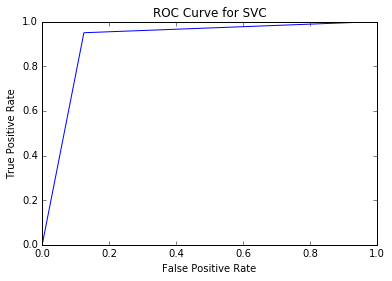

In [8]:
model=SVC(gamma=0.005,C=100)
name="SVC"
data=[trainX,trainY,testX,testY,X,Y]
fit(model,name,data)

### RFC

#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.962382
f1 score from CV5 0.958143
[[279  10]
 [ 14 307]]


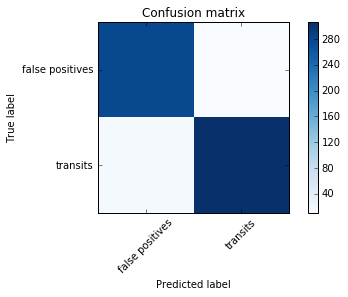

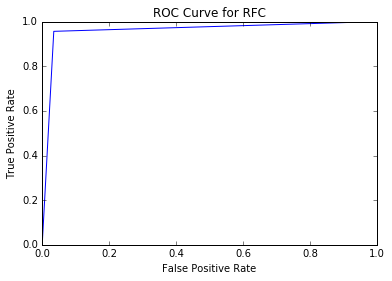

In [9]:
model=RandomForestClassifier(n_estimators=1000)
name="RFC"
fit(model,name,data)

### GBC

#####################################
Result using GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
f1 score from train test split 0.965300
f1 score from CV5 0.962979
[[282   7]
 [ 15 306]]


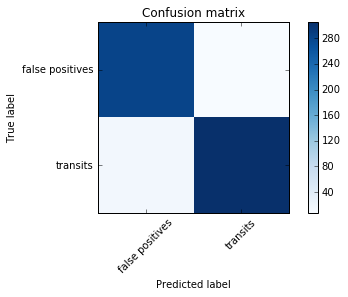

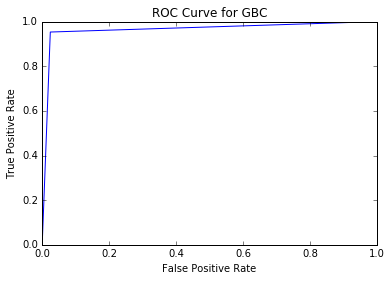

In [10]:
model=GradientBoostingClassifier(n_estimators=1000)
name="GBC"
fit(model,name,data)

## Frequency Spectra Features

### SVM

In [11]:
SVM_data=pd.read_csv("data/BL_CR_BLS_SVM_features.csv",index_col=0)
SVM_data.head()

,P17,P5,P4,P12,BLS29,P18,BLS3,BLS2,P11,BLS0,...,BLS23,P8,BLS25,BLS6,P0,BLS12,BLS21,BLS10,Y,IDs
684,0.00177,0.02800,0.01688,11,0.322894,31.72044,-0.626337,0.081487,1.00000,1.320577,...,0.114407,0.58729,-0.260834,-0.102534,4.807470,0.378214,-0.630729,-0.021092,1,1684
559,0.00275,0.01435,0.01297,8,0.327270,12.25300,-1.785808,-0.862720,0.36167,-1.440378,...,-1.636120,0.23961,0.018934,-0.393561,0.736732,-0.417697,0.289651,-1.391188,1,1559
629,0.00172,0.05325,0.01786,24,-0.926112,50.75688,0.534109,2.068404,0.35051,0.196805,...,0.227809,0.69205,0.229622,-1.113207,2.170708,0.438427,-0.397383,0.737376,1,1629
192,0.00229,0.05530,0.00933,38,0.272111,9.22637,-0.518754,0.435421,0.99915,0.582126,...,0.013762,0.20962,-0.302891,-0.387688,1.766593,-0.910080,-0.805869,0.027352,1,1192
835,0.00578,0.03578,0.01634,19,0.018857,12.33050,-0.472106,0.017020,0.60653,0.364031,...,1.747502,0.54715,-0.451786,-0.040582,2.988182,0.744240,-0.774114,-0.430263,1,1835


In [12]:
X=SVM_data.drop(['Y','IDs'],axis=1)
Y=SVM_data['Y']
IDs=SVM_data['IDs']
X=StandardScaler().fit_transform(X)
trainX, testX, trainY, testY,trainIDs,testIDs= train_test_split(X, Y,IDs,test_size = 0.2)

#####################################
Result using SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
f1 score from train test split 0.949914
f1 score from CV5 0.926258
[[196  18]
 [ 11 275]]


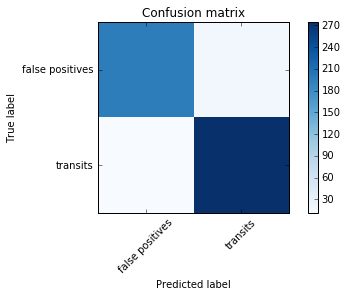

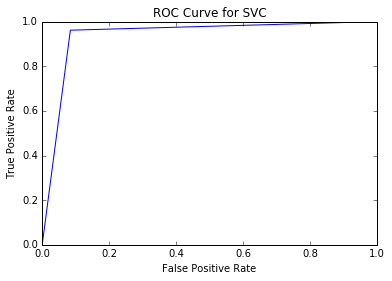

In [13]:
model=SVC(gamma=0.05,C=50)
name="SVC"
data=[trainX,trainY,testX,testY,X,Y]
fit(model,name,data)

[ 1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.  5500.
  6000.  6500.  7000.]


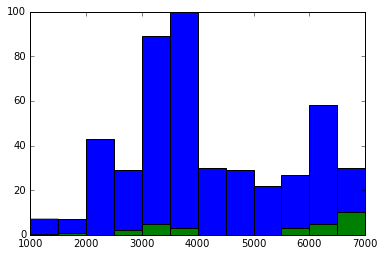

In [14]:
check_FPs(model,testX,testY,testIDs)

### RFC

In [15]:
RFC_data=pd.read_csv("data/BL_CR_BLS_RFC_features.csv",index_col=0)
X=RFC_data.drop(['Y','IDs'],axis=1)
X=StandardScaler().fit_transform(X)
Y=RFC_data['Y']
IDs=RFC_data['IDs']
trainX, testX, trainY, testY,trainIDs,testIDs= train_test_split(X, Y,IDs,test_size = 0.2)
#RFC_data.head()

#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.953416
f1 score from CV5 0.943348
[[163  22]
 [  8 307]]


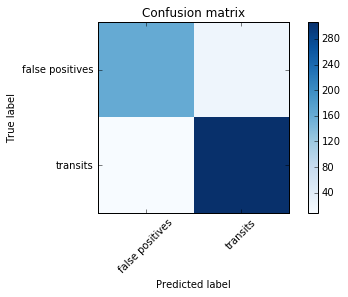

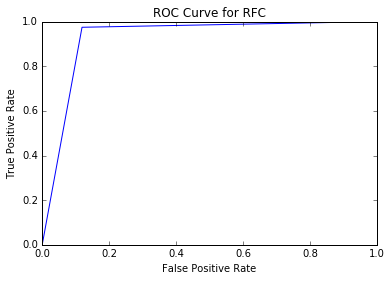

In [16]:
model=RandomForestClassifier(n_estimators=1000)
name="RFC"
data=[trainX,trainY,testX,testY,X,Y]
fit(model,name,data)

[ 1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.  5500.
  6000.  6500.  7000.]


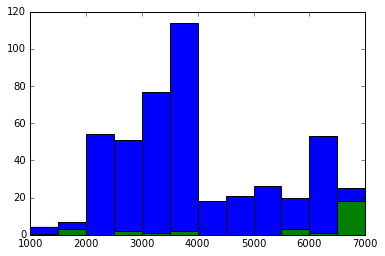

In [17]:
check_FPs(model,testX,testY,testIDs)

### GBC

In [18]:
GBC_data=pd.read_csv("data/BL_CR_BLS_GBC_features.csv",index_col=0)
X=GBC_data.drop(['Y','IDs'],axis=1)
X=StandardScaler().fit_transform(X)
Y=GBC_data['Y']
IDs=GBC_data['IDs']
trainX, testX, trainY, testY,trainIDs,testIDs= train_test_split(X, Y,IDs,test_size = 0.2)
#GBC_data.head()

#####################################
Result using GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
f1 score from train test split 0.978261
f1 score from CV5 0.947199
[[171   8]
 [  6 315]]


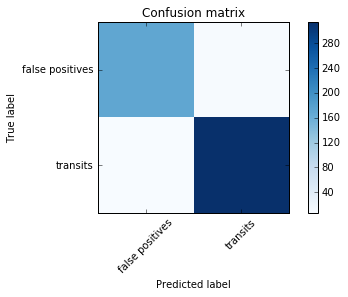

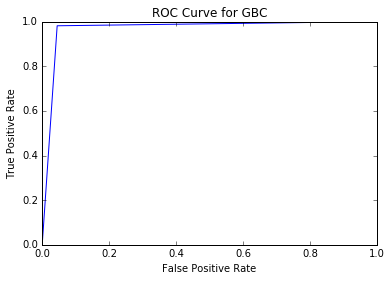

In [19]:
model=GradientBoostingClassifier(n_estimators=1000)
name="GBC"
data=[trainX,trainY,testX,testY,X,Y]
fit(model,name,data)

[ 1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.  5500.
  6000.  6500.  7000.]


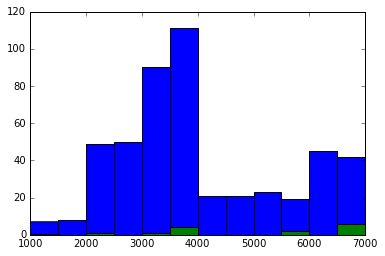

In [20]:
check_FPs(model,testX,testY,testIDs)